An **AutoEncoder** is an unsupervised learning algorithm. In our example here it takes an image as input and then tries to *reconstruct* that image using less information. 

They do this by projecting higher dimensional data to a lower dimension (similar to Principal Component Analysis) by keeping the features of most importance. this called the **latent space**.

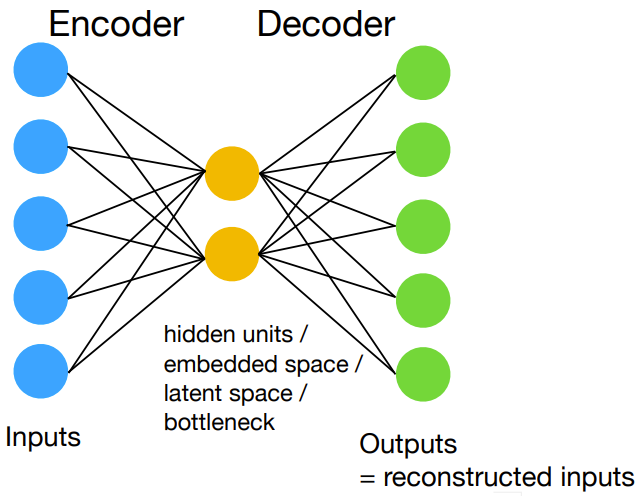

## 1) Import Libraries 

In [1]:
import os 
import numpy as np 
import matplotlib.pyplot as plt 

import torch 
import torchvision 
import torch.nn as nn 
import torchvision.transforms as transforms 
import torch.optim as optim 
import torch.nn.functional as F 

from torchvision import datasets 
from torch.utils.data import DataLoader 
from torchvision.utils import save_image 

## Select Your Device 

In [9]:
print("GPU available: {}".format(torch.cuda.is_available()))

if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

GPU available: True


## 2) Data Preprocessing 

In [2]:
transform = transforms.Compose([transforms.ToTensor(),])

In [3]:
trainset = datasets.FashionMNIST(root = './data',
                                 train = True,
                                 download = True,
                                 transform = transform)

testset = datasets.FashionMNIST(root = './data',
                                train = False,
                                download = True,
                                transform = transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
Batch_Size = 128

trainloader = DataLoader(trainset,
                         batch_size = Batch_Size,
                         shuffle = True)

testloader = DataLoader(testset,
                        batch_size = Batch_Size,
                        shuffle = True)

## 3) Build the Model:

FashionMNIST Dataset has **28x28** pixels image with **1-channel**.

The **Encoder** produces the latent code representation which then goes to the **Decoder** for reconstruction.

Actually, we don't even need such a large network for the Fashion MNIST dataset. Even two linear layers can effectively capture all the important features of the images. 

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        # Encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
        
        # Decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
        
    def forward(self, x):
        
        # Encoder
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
        
        # Decoder
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        
        return x 

model = AutoEncoder()
print('Model Architectur', model)

Model Architectur AutoEncoder(
  (enc1): Linear(in_features=784, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=128, bias=True)
  (enc3): Linear(in_features=128, out_features=64, bias=True)
  (enc4): Linear(in_features=64, out_features=32, bias=True)
  (enc5): Linear(in_features=32, out_features=16, bias=True)
  (dec1): Linear(in_features=16, out_features=32, bias=True)
  (dec2): Linear(in_features=32, out_features=64, bias=True)
  (dec3): Linear(in_features=64, out_features=128, bias=True)
  (dec4): Linear(in_features=128, out_features=256, bias=True)
  (dec5): Linear(in_features=256, out_features=784, bias=True)
)


## Setting Hyperparameters

In [6]:
num_classes = 10
num_epochs = 50
BATCH_SIZE = 128
LEARNING_RATE = 1e-3

# Define the loss function 
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [7]:
def make_dir():
    image_dir = 'FashionMNIST_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
        
def save_decoded_image(img, epoch):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, './FashionMNIST_Images/linear_ae_image{}.png'.format(epoch))

## 4) Training Time

In [13]:
num_samples = len(trainloader)
train_loss = []

#Create a folder to store decoded images 
make_dir()

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in trainloader:
        
        #Move Model to the device
        model = model.to(device)
        #Move tensors to the configured device
        image, _ = data
        image = image.to(device)
        image = image.view(image.size(0), -1)
        
        #Forward Pass 
        outputs = model(image)
        loss = criterion(outputs, image)
        
        #Backward and optimization 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss = running_loss / num_samples
    train_loss.append(loss)
    print('Epoch {} of {}, Train Loss: {:.3f}'.format(epoch, num_epochs, loss))
    
    if epoch % 5 == 0:
        #move output images from GPU to CPU 
        save_decoded_image(outputs.cpu().data, epoch)

Epoch 0 of 50, Train Loss: 0.026
Epoch 1 of 50, Train Loss: 0.025
Epoch 2 of 50, Train Loss: 0.024
Epoch 3 of 50, Train Loss: 0.023
Epoch 4 of 50, Train Loss: 0.022
Epoch 5 of 50, Train Loss: 0.022
Epoch 6 of 50, Train Loss: 0.021
Epoch 7 of 50, Train Loss: 0.021
Epoch 8 of 50, Train Loss: 0.021
Epoch 9 of 50, Train Loss: 0.020
Epoch 10 of 50, Train Loss: 0.020
Epoch 11 of 50, Train Loss: 0.020
Epoch 12 of 50, Train Loss: 0.020
Epoch 13 of 50, Train Loss: 0.019
Epoch 14 of 50, Train Loss: 0.019
Epoch 15 of 50, Train Loss: 0.019
Epoch 16 of 50, Train Loss: 0.019
Epoch 17 of 50, Train Loss: 0.019
Epoch 18 of 50, Train Loss: 0.019
Epoch 19 of 50, Train Loss: 0.018
Epoch 20 of 50, Train Loss: 0.018
Epoch 21 of 50, Train Loss: 0.018
Epoch 22 of 50, Train Loss: 0.018
Epoch 23 of 50, Train Loss: 0.018
Epoch 24 of 50, Train Loss: 0.018
Epoch 25 of 50, Train Loss: 0.018
Epoch 26 of 50, Train Loss: 0.018
Epoch 27 of 50, Train Loss: 0.018
Epoch 28 of 50, Train Loss: 0.018
Epoch 29 of 50, Train Lo

## Plot Training Results 

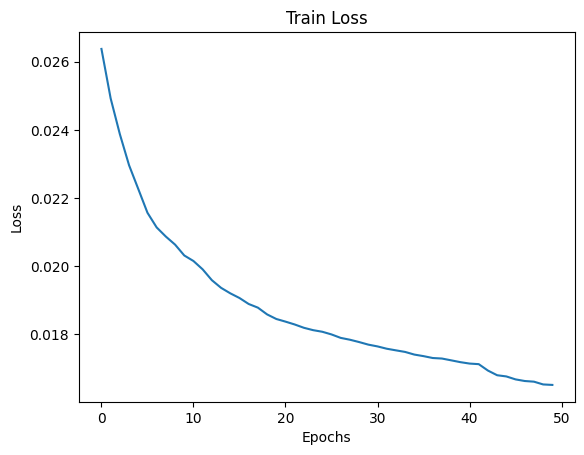

In [14]:
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('Deep_ae_fashionmnist_loss.png')

In [15]:
for batch in testloader:
        image, _ = batch
        image = image.to(device)
        image = image.view(image.size(0), -1)
        outputs = model(image)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        save_image(outputs, 'fashionmnist_reconstruction0.png')
        break     

## 5) Display The Results 

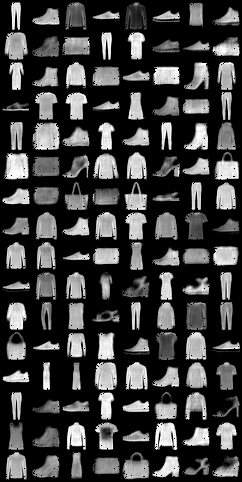

In [16]:
from IPython.display import Image

Image('fashionmnist_reconstruction0.png')

## View The Original Images 

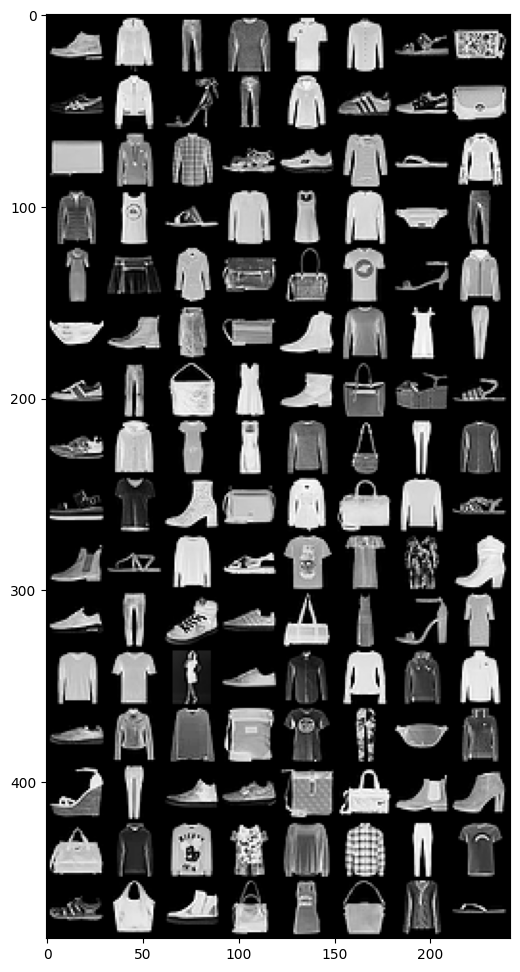

In [17]:
#Function to show an image 
def imshow(image):
    img = image.numpy()
    plt.figure(figsize=(8,12))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    
#Get some training examples 
dataiter = iter(trainloader)
images, labels = next(dataiter)

#Show Images 
imshow(torchvision.utils.make_grid(images))